# Movie Recommendation System
Students: Will Bennett, James Meredith

Instructor: David Elliot

Active Project Dates: May 29th - June 2nd

In [177]:
# Standard imports
import pandas as pd
import numpy as np
from random import gauss, uniform as uni, seed
import math as math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Imports required libraries for the model
from surprise import Dataset, Reader
from surprise.prediction_algorithms import *
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.accuracy import rmse, mae


## Data Preperation & Cleaning

In [129]:
# Load data
df_movies = pd.read_csv('ml-latest-small/movies.csv')
df_tags = pd.read_csv('ml-latest-small/tags.csv')
df_ratings = pd.read_csv('ml-latest-small/ratings.csv')

We can check out each data table, we will start with movies

### Movies

In [130]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We have an ID, a title, and a genre (separated by |)

Let's check for data types and missing data

In [131]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


It seems as if the movie data set is fairly clean, we can work with this

Next let's handle duplicates

In [132]:
#Check for duplicates
df_movies['title'].duplicated().value_counts()

False    9737
True        5
Name: title, dtype: int64

We will start by cleaning our data

In [133]:
df_movies_clean = df_movies
df_movies_clean.columns = df_movies.columns.str.lower()

In [134]:
# Investigate Duplcates
df_movies_clean = df_movies.drop_duplicates(subset='title', keep='first').reset_index(drop=True)
df_movies_clean

,movieid,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9732,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9733,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9734,193585,Flint (2017),Drama
9735,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


That has removed the duplicates, now let's handle genres

We can start by creating dummy variables for all the genres

In [135]:
movie_genres = df_movies_clean['genres'].str.get_dummies()

df_movies_clean = pd.concat([df_movies_clean, movie_genres], axis=1, join='inner')
df_movies_clean

,movieid,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9732,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9733,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9734,193585,Flint (2017),Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9735,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that we've separated out the genres we can drop the genre column from movies

In [136]:
df_movies_clean = df_movies_clean.drop('genres', axis=1)

In [137]:
df_movies_clean

,movieid,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9732,193581,Black Butler: Book of the Atlantic (2017),0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9733,193583,No Game No Life: Zero (2017),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9734,193585,Flint (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9735,193587,Bungo Stray Dogs: Dead Apple (2018),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We only need to keep movies with ratings

In [138]:
df_movies_clean = df_movies_clean[df_movies_clean['movieid'].isin(df_ratings.movieId)].reset_index(drop=True)
df_movies_clean

,movieid,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9714,193581,Black Butler: Book of the Atlantic (2017),0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9715,193583,No Game No Life: Zero (2017),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9716,193585,Flint (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9717,193587,Bungo Stray Dogs: Dead Apple (2018),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Tags

In [139]:
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [140]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


It looks like we will need to clean the tags but there is no missing data.

We can likely drop the timestamp and user ID columns as well

In [141]:
df_tags_clean = df_tags
df_tags_clean.columns = df_tags_clean.columns.str.lower()
df_tags_clean = df_tags_clean.drop(columns=['userid', 'timestamp'], axis=1)
df_tags_clean['tag'] = df_tags_clean['tag'].str.lower()
df_tags_clean.head()

,movieid,tag
0,60756,funny
1,60756,highly quotable
2,60756,will ferrell
3,89774,boxing story
4,89774,mma


We will need to convert the tags to dummies

In [142]:
df_tags_clean = df_tags_clean.groupby('movieid')['tag'].apply(list).reset_index()
df_tags_clean

,movieid,tag
0,1,"[pixar, pixar, fun]"
1,2,"[fantasy, magic board game, robin williams, game]"
2,3,"[moldy, old]"
3,5,"[pregnancy, remake]"
4,7,[remake]
...,...,...
1567,183611,"[comedy, funny, rachel mcadams]"
1568,184471,"[adventure, alicia vikander, video game adapta..."
1569,187593,"[josh brolin, ryan reynolds, sarcasm]"
1570,187595,"[emilia clarke, star wars]"


In [143]:
movie_tags = df_tags_clean['tag'].explode().str.get_dummies().groupby(level=0).sum()
movie_tags

,"""artsy""",06 oscar nominated best movie - animation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,2001-like,...,world war i,world war ii,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies,zooey deschanel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
df_tags_clean = pd.concat([df_tags_clean, movie_tags], axis=1, join='inner')
df_tags_clean

,movieid,tag,"""artsy""",06 oscar nominated best movie - animation,1900s,1920s,1950s,1960s,1970s,1980s,...,world war i,world war ii,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies,zooey deschanel
0,1,"[pixar, pixar, fun]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,"[fantasy, magic board game, robin williams, game]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,"[moldy, old]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,"[pregnancy, remake]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,[remake],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,183611,"[comedy, funny, rachel mcadams]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1568,184471,"[adventure, alicia vikander, video game adapta...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1569,187593,"[josh brolin, ryan reynolds, sarcasm]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1570,187595,"[emilia clarke, star wars]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [145]:
df_tags_clean = df_tags_clean.drop('tag', axis=1)
df_tags_clean

,movieid,"""artsy""",06 oscar nominated best movie - animation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,...,world war i,world war ii,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies,zooey deschanel
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,183611,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1568,184471,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1569,187593,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1570,187595,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Ratings

In [146]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [147]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [148]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


This dataset is clean as well with no missing data, we may not need the timestamp column here

In [149]:
df_ratings_clean = df_ratings
df_ratings_clean.columns = df_ratings_clean.columns.str.lower()
df_ratings_clean = df_ratings_clean.drop('timestamp', axis=1)
df_ratings_clean.head()

,userid,movieid,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


We should only keep ratings for movies that we have genre data for

In [150]:
df_ratings_clean = df_ratings_clean[df_ratings_clean['movieid'].isin(df_movies_clean.movieid)].reset_index(drop=True)
df_ratings_clean

,userid,movieid,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100825,610,166534,4.0
100826,610,168248,5.0
100827,610,168250,5.0
100828,610,168252,5.0


In [151]:
df_ratings_clean = df_ratings_clean.pivot(index='userid', columns='movieid', values='rating').reset_index().fillna(0)
df_ratings_clean

movieid,userid,1,2,3,4,5,6,7,8,9,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,609,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Exploration

In [223]:
df_ratings.groupby('movieid')['rating'].count().reset_index().sort_values(by='rating', ascending=False)

,movieid,rating
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278
...,...,...
3053,4093,1
3049,4089,1
6687,58351,1
3045,4083,1


In [226]:
rating_counts.columns

Index(['movieid', 'rating'], dtype='object')

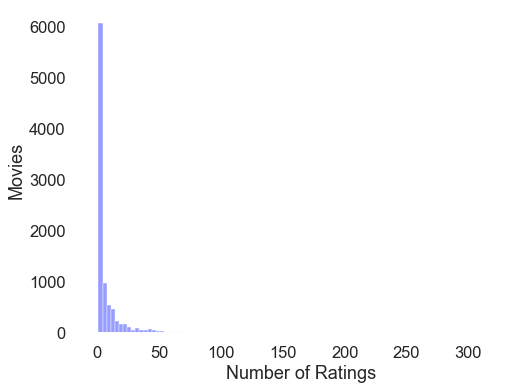

In [236]:
fig, ax = plt.subplots(figsize=(8,6))
sns.set_context("talk")

rating_counts = df_ratings.groupby('movieid')['rating'].count().reset_index().sort_values(by='rating', ascending=False)

plt.rcParams.update({
    "savefig.transparent": True
})

n_bins = round(np.sqrt(len(rating_counts)))

sns.histplot(rating_counts['rating'], bins=n_bins, color='#757cff')
ax.set_xlabel('Number of Ratings')
ax.set_ylabel('Movies')
ax.grid(False)
sns.despine(left=True)
plt.savefig('images/long-tail.png');

There is a long tail in movies that aren't rate, that's where a recommendation system can shine

Movie breakdown by genre

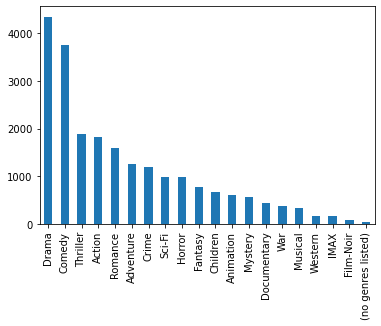

In [153]:
data = df_movies_clean.drop(['movieid', 'title'], axis=1).agg('sum').sort_values(ascending=False)

data.plot.bar();

## Modeling

### Content-Based Model using Cosine Similarity

We'll use the genres and tags to create a content-based model using cosine similarity

In [154]:
# Imports required libraries for the model
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [155]:
df_movies_clean

,movieid,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9714,193581,Black Butler: Book of the Atlantic (2017),0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9715,193583,No Game No Life: Zero (2017),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9716,193585,Flint (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9717,193587,Bungo Stray Dogs: Dead Apple (2018),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [156]:
df_tags_clean

,movieid,"""artsy""",06 oscar nominated best movie - animation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,...,world war i,world war ii,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies,zooey deschanel
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,183611,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1568,184471,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1569,187593,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1570,187595,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [157]:
# Concatenates the two dataframes to create a new dataframe with all the features
df_features = pd.concat([df_movies_clean, df_tags_clean], axis=1, join='inner')
df_features.drop(['title', '(no genres listed)'], axis=1, inplace=True)

In [158]:
df_features

,movieid,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,world war i,world war ii,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies,zooey deschanel
0,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,2106,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1568,2107,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1569,2108,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1570,2109,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [159]:
# Computes cosine similarity matrix using the dataframe with all the features
similarity_matrix = cosine_similarity(df_features)

Generating Recommendations:
Here we show an example of how the content-based recommendation system works. We will use the movie "Toy Story" (movieid 1) as an example. We can see that the model recommends other movies that are similar to Toy Story.

In [160]:
# Assuming you want to recommend movies to a user based on a target movie they have already watched. For example, the user has watched movie 1 and you want to recommend similar movies to them.
target_movie = 0
# Computes the similarity scores between the target movie and all other movies
movie_similarities = similarity_matrix[target_movie]
# Returns the indices of movies with the highest similarity scores
most_similar_movie_indices = np.argsort(movie_similarities)[::-1]
# Generate Top 5 recommendations based on the most similar users, excluding the target itself
top_5_recommendations = most_similar_movie_indices[2:7]  # Exclude the target user itself
# Uses top_5_recommendations to get the movie titles in the order of recommendations
df_movies_clean[df_movies_clean['movieid'].isin(top_5_recommendations)]['title']

1                         Jumanji (1995)
2                Grumpier Old Men (1995)
3               Waiting to Exhale (1995)
6                         Sabrina (1995)
11    Dracula: Dead and Loving It (1995)
Name: title, dtype: object

### Collaborative Filtering

We'll start by using the surprise library to build a collaborative filtering model here.

In [161]:
# Drops the timestamp column from the ratings dataframe to prepare it for model training
df_ratings_surprise = df_ratings.drop('timestamp', axis=1)

We should only keep ratings for movies that we have genre data for

In [162]:
# # Defines the rating scale (from 1 to 5) and loads the data into the Surprise Dataset format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_ratings_surprise[['userid', 'movieid', 'rating']], reader)

In [163]:
# Splits data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

In [164]:
# Defines a list of predcition algorithms to be used for model training
algorithms = [
    KNNBasic(),
    KNNWithMeans(),
    KNNWithZScore(),
    KNNBaseline(),
    SVD(),
    CoClustering(),
    # Due to the computational demands of the following algorithms, they are omitted from the list of algorithms to be used for model training
    # SVDpp(), 
    # NMF(),
    # SlopeOne(),
]

In [165]:
# Compares the algorithms using cross-validation
for algorithm in algorithms:
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    print(f'{algorithm.__class__.__name__}:')
    print('  RMSE:', results['test_rmse'].mean())
    print('  MAE:', results['test_mae'].mean())
    print('')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNBasic:
  RMSE: 0.947128860088845
  MAE: 0.7262138029694227

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNWithMeans:
  RMSE: 0.8947908373121074
  MAE: 0.6836336698571619

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity m

**Observations:**

KNNBAseline and SVD consistently scored the lowest RMSE on our tests. Based on the RMSE we can see that the SVD model performs the best, so we will use that for our recommendations.


**Tuning the Hyperparameters:**

We will use GridSearchCV to tune the hyperparameters for our SVD model. We will use the RMSE as our scoring metric.

In [166]:
# Defines the parameter grid for hyperparameter tuning
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.002, 0.005, 0.008], 'reg_all': [0.02, 0.04, 0.06]}
# Performs grid search cross-validation to find the best hyperparameters for the SVD algorithm
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
# Fits the grid search object to the data
gs.fit(data)

In [167]:
# Gets the best hyperparameter combination
best_params = gs.best_params['rmse']
print('Best Parameters:', best_params)

Best Parameters: {'n_epochs': 30, 'lr_all': 0.008, 'reg_all': 0.06}


In [168]:
# Trains the model with the best hyperparameters on the training set
model = SVD(n_epochs=best_params['n_epochs'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
model.fit(trainset)

In [220]:
# Get the RMSE of the best SVD Model
results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
print('  RMSE:', results['test_rmse'].mean())
print('  MAE:', results['test_mae'].mean())
print('')

  RMSE: 0.8559336492505715
  MAE: 0.6553251418304487



**Generating Recommendations:**

He we show an example of how the collaborative filtering recommendation system works. We will use the user with the ID of 1 as an example. We can see that the model recommends movies that the user has not seen yet.

In [171]:
df_ratings_surprise

,userid,movieid,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [174]:
# Generates recommendations for a specific user
user_id = '1'
movies_rated = df_ratings_surprise[df_ratings_surprise['userid'] == user_id]
movies_not_rated = df_movies_clean[~df_movies_clean['movieid'].isin(movies_rated['movieid'])]['movieid']
predictions = [model.predict(user_id, movie_id) for movie_id in movies_not_rated]
sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)
# Removes duplicates from sorted predictions
unique_movie_ids = set()
top_recommendations = []
for pred in sorted_predictions:
    if pred.iid not in unique_movie_ids:
        top_recommendations.append(pred.iid)
        unique_movie_ids.add(pred.iid)
        if len(top_recommendations) == 5:
            break

# Returns the movie titles of the top recommendations
df_movies_clean[df_movies_clean['movieid'].isin(top_recommendations)]['title']

840        Streetcar Named Desire, A (1951)
2281                         Yojimbo (1961)
2565                Double Indemnity (1944)
2579    Guess Who's Coming to Dinner (1967)
7684                      The Artist (2011)
Name: title, dtype: object

### Aleternating Least-Squares (ALS)

Let's start by doing ALS by hand!

Our setup
- Users: m x n (m users)
- Items: r x n (r items)
- Ratings: m x r

n = 10 randomly generated latent features to start

We will start by creating a dataframe for users ratings

In [175]:
ratings_arr = df_ratings_clean.set_index('userid')
ratings_arr

movieid,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userid,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will start by randomly generating the user matrix with 10 latent features

In [178]:
users = []
seed(42)
m_users = len(ratings_arr)

# Random generation of values for the user matrix
for _ in range(m_users):
    user = []
    for _ in range(10):
        user.append(gauss(0, 1))
    users.append(user)
users_arr = np.array(users)
users_arr.shape

(610, 10)

Next we will do the same for items

In [179]:
items = []
n_items = len(ratings_arr.columns)

# Random generation of values for the item matrix
for _ in range(n_items):
    item = []
    for _ in range(10):
        item.append(gauss(0, 1))
    items.append(item)
items_arr = np.array(items)
items_arr.shape

(9719, 10)

Our first guess can be the matrix product of our user and item matricies (it will be quite off)

In [180]:
guess = users_arr.dot(items_arr.T)
guess.shape

(610, 9719)

Let's check the RMSE of our initial guess

In [181]:
rmse = np.sqrt(mean_squared_error(ratings_arr, guess))
rmse

3.200853727944686

Now let's implement ALS, switching between optimizing our user and item matricies

In [182]:
ratings_cols = ratings_arr.T
items = items_arr
reps = 10
    
for rep in range(reps):
    new_users = []
    
    for i in list(ratings_arr.index):
        
        user = LinearRegression(fit_intercept=False).fit(items, ratings_cols[i]).coef_
        new_users.append(user)
        
    new_users = np.asarray(new_users)
    
    
    
    new_items = []
    
    for i in list(ratings_cols.index):
        
        item = LinearRegression(fit_intercept=False).fit(new_users, ratings_arr[i]).coef_
        new_items.append(item)
        
    new_items = np.asarray(new_items)
    
    
    
    df_user_pref = new_users.dot(new_items.T)
    rmse = np.sqrt(mean_squared_error(ratings_arr, df_user_pref))
    print(f'Iteration {rep} RMSE: {rmse}')
    
    items = new_items
    
    new_users.dot(new_items.T)

Iteration 0 RMSE: 0.4262879156002728
Iteration 1 RMSE: 0.38463775871075007
Iteration 2 RMSE: 0.3795288738642368
Iteration 3 RMSE: 0.3775771613052784
Iteration 4 RMSE: 0.3767891741016208
Iteration 5 RMSE: 0.3764152914485567
Iteration 6 RMSE: 0.37620844122493524
Iteration 7 RMSE: 0.37608245293455306
Iteration 8 RMSE: 0.3759955916689529
Iteration 9 RMSE: 0.37592357813151134


Our final RMSE is 0.38 which is definitely better than our original RMSE of 0.46

That's how we can optimize our recommendations using ALS!

Now it's time to actually generate some recommendations

In [183]:
user_pred = pd.DataFrame(df_user_pref)
user_pred.columns = ratings_arr.columns
user_pred['userid'] = list(ratings_arr.index)
user_pred = user_pred.set_index('userid')
user_pred

movieid,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userid,,,,,,,,,,,,,,,,,,,,,
1,2.904486,0.904965,0.958981,-0.020478,0.210584,1.658656,0.127516,-0.008853,0.150712,1.994945,...,-0.010704,-0.009175,-0.012233,-0.012233,-0.010704,-0.012233,-0.010704,-0.010704,-0.010704,-0.020123
2,0.269590,0.013163,-0.025158,0.006312,0.044893,0.005812,-0.038042,0.002351,-0.006525,-0.085779,...,0.007438,0.006375,0.008500,0.008500,0.007438,0.008500,0.007438,0.007438,0.007438,0.013175
3,0.030456,0.018993,0.018943,-0.004290,-0.015756,0.076976,-0.011049,-0.000177,0.008779,0.064229,...,0.000389,0.000334,0.000445,0.000445,0.000389,0.000445,0.000389,0.000389,0.000389,-0.001908
4,1.497490,0.075850,0.286128,0.037736,0.155599,0.390456,0.301439,-0.038799,-0.022664,0.072857,...,-0.001451,-0.001243,-0.001658,-0.001658,-0.001451,-0.001658,-0.001451,-0.001451,-0.001451,-0.008116
5,1.231532,0.919166,0.414655,0.119250,0.515611,0.830160,0.616821,0.124869,0.114262,1.160460,...,0.000233,0.000199,0.000266,0.000266,0.000233,0.000266,0.000233,0.000233,0.000233,0.000574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,1.206448,1.260136,-1.367333,0.100320,-0.378195,1.515600,1.975341,-0.229041,-0.116950,-0.027646,...,0.007684,0.006586,0.008782,0.008782,0.007684,0.008782,0.007684,0.007684,0.007684,-0.056098
607,2.475238,1.181937,0.644954,0.043948,0.318467,1.627257,0.315325,0.023200,0.136416,1.918624,...,-0.009464,-0.008112,-0.010816,-0.010816,-0.009464,-0.010816,-0.009464,-0.009464,-0.009464,-0.016290
608,2.640211,2.121780,1.723790,-0.076522,0.399458,3.400993,0.496738,0.377578,0.201133,3.975899,...,-0.057181,-0.049012,-0.065350,-0.065350,-0.057181,-0.065350,-0.057181,-0.057181,-0.057181,-0.008065


In [184]:
user_top_movies = user_pred.unstack().reset_index()
user_top_movies.columns = ['movieid', 'userid', 'rating']
user_top_movies

,movieid,userid,rating
0,1,1,2.904486
1,1,2,0.269590
2,1,3,0.030456
3,1,4,1.497490
4,1,5,1.231532
...,...,...,...
5928585,193609,606,-0.056098
5928586,193609,607,-0.016290
5928587,193609,608,-0.008065
5928588,193609,609,0.001241


In [185]:
user_10_top = user_top_movies[['userid', 'movieid', 'rating']].groupby("userid", as_index=False).apply(lambda df:df.sort_values("rating", ascending=False)
.head(10)).droplevel(0)
user_10_top[user_10_top['userid'] == 1]

,userid,movieid,rating
136640,1,260,4.741094
547170,1,1196,4.670753
555100,1,1210,4.199701
548390,1,1198,4.019209
1182180,1,2571,3.761896
547780,1,1197,3.585260
603290,1,1291,3.489484
309270,1,589,3.465654
916220,1,2028,3.462904
590480,1,1270,3.420470


In [186]:
user_10_top.shape

(6100, 3)

Now we need to add the titles back in

In [187]:
movie_names = df_movies_clean[['movieid', 'title']].set_index('movieid')
als_recommendations = user_10_top.join(movie_names, on='movieid')

Example pull top 10 recommendations for user 0

In [188]:
df_ratings[df_ratings['userid']==2].join(movie_names, on='movieid').sort_values(by='rating', ascending=False)

,userid,movieid,rating,timestamp,title
260,2,131724,5.0,1445714851,The Jinx: The Life and Deaths of Robert Durst ...
259,2,122882,5.0,1445715272,Mad Max: Fury Road (2015)
254,2,106782,5.0,1445714966,"Wolf of Wall Street, The (2013)"
250,2,89774,5.0,1445715189,Warrior (2011)
241,2,60756,5.0,1445714980,Step Brothers (2008)
248,2,80906,5.0,1445715172,Inside Job (2010)
234,2,1704,4.5,1445715228,Good Will Hunting (1997)
240,2,58559,4.5,1445715141,"Dark Knight, The (2008)"
242,2,68157,4.5,1445715154,Inglourious Basterds (2009)
247,2,80489,4.5,1445715340,"Town, The (2010)"
